In [1]:
import cv2
import os
import time
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Flatten, ConvLSTM2D, Reshape, BatchNormalization, Input, TimeDistributed, AdditiveAttention
from tensorflow.keras.models import load_model, Model
from seq_generator_v2 import FrameGeneratorAffWildPoolV2
from seq_generator_v3 import FrameGeneratorAffWildPoolV3

2024-06-27 14:21:27.799991: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 14:21:27.851130: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 14:21:27.851168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 14:21:27.852698: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 14:21:27.861876: I tensorflow/core/platform/cpu_feature_guar

# Constants

In [2]:
ruta_labels_train = '/home/jupyter/tpp/datasets/unprocessed/affwild_labels/EXPR_Classification_Challenge/Train_Set'
ruta_labels_validation = '/home/jupyter/tpp/datasets/unprocessed/affwild_labels/EXPR_Classification_Challenge/Validation_Set'
ruta_imagenes = '/home/jupyter/tpp/datasets/unprocessed/cropped_aligned'
videos_train = ['325', '326', '327']
videos_validation = ['121-24-1920x1080']#['135', '136']

In [3]:
emociones = ['Neutral', 'Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise']
IMG_SIZE = 112
IMG_CHANNELS = 3
MAX_SEQ_LENGTH = 10
NUM_FEATURES = 1024
EPOCHS = 50
BATCH_SIZE= 512
DILATION = 6

# Load CNN model

In [4]:
from keras.models import model_from_json, Sequential, load_model
from keras.src.saving import serialization_lib


serialization_lib.enable_unsafe_deserialization()

MODELS_PATH = "../Modelos/"
cnn_model_name = "vgg16_cota_112.keras"

In [5]:
def load_modal_json():
    with open(MODELS_PATH + cnn_model_name + '.json','r') as f:
        json = f.read()
    cnn_model = model_from_json(json)

    cnn_model.load_weights(MODELS_PATH + cnn_model_name + '.h5')
    print(f"Loaded model {cnn_model_name} from disk")
    return cnn_model

In [6]:
def load_model_keras():
    model = load_model(MODELS_PATH + cnn_model_name)
    return model

In [7]:
cnn_model = load_model_keras()

2024-06-27 14:21:36.990903: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38197 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [8]:
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 112, 112, 3)       0         
                                                                 
 lambda (Lambda)             (None, 112, 112, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [9]:
model = Sequential()
for layer in cnn_model.layers[:-1]: # go through until last layer
    model.add(layer)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 112, 112, 3)       0         
                                                                 
 lambda (Lambda)             (None, 112, 112, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                        

In [10]:
image = plt.imread('/home/jupyter/tpp/datasets/processed/merge_data/Anger/affwild_pr_9-15-1920x1080_28357.jpg')

image = np.expand_dims(image, axis=0)
image.shape

(1, 112, 112, 3)

In [11]:
#image_zero = np.zeros(shape=(1, IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype="float32")
result = model.predict(image)

2024-06-27 14:21:53.906061: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900


1/1 [==============================] - 5s 5s/step


In [12]:
result[0][450:470]

array([ 0.      ,  0.      ,  0.      , 38.905876,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ], dtype=float32)

# Data Generator

In [13]:
def getFrameGeneratorTrain():
    return FrameGeneratorAffWildPoolV2(len(emociones), model, ruta_labels_train, ruta_imagenes, MAX_SEQ_LENGTH, NUM_FEATURES, IMG_SIZE, IMG_CHANNELS, videos_names=videos_train, verbose=False)

fg = getFrameGeneratorTrain()

Generator for videos ['325', '326', '327']


In [14]:
def getFrameGeneratorValidation():
    return FrameGeneratorAffWildPoolV2(len(emociones), model, ruta_labels_validation, ruta_imagenes, MAX_SEQ_LENGTH, NUM_FEATURES, IMG_SIZE, IMG_CHANNELS, videos_names=videos_validation, verbose=True)

fg = getFrameGeneratorValidation()
data = fg()

Generator for videos ['121-24-1920x1080']


  0%|          | 0/1 [00:00<?, ?it/s]

Processing video 121-24-1920x1080


# Sequence model

In [15]:
base_learning_rate = 0.0001

In [16]:
# Utility for our sequence model.
def get_sequence_model_att():
    frame_features_input = Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = Input((MAX_SEQ_LENGTH), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    lstm = LSTM(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    # Bahdanau Attention layer
    attention_layer = AdditiveAttention()
    context_vector = attention_layer([lstm, lstm])

    #x = LSTM(8, return_sequences=True)(context_vector)
    #x = Dropout(0.4)(x)
    x = Dense(8, activation="relu")(context_vector)
    output = TimeDistributed(Dense(len(emociones), activation="softmax"))(x)

    rnn_model = Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), metrics=["accuracy"]
    )
    return rnn_model

In [17]:
# Utility for our sequence model.
def get_sequence_model():
    frame_features_input = Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = Input((MAX_SEQ_LENGTH), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = LSTM(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = LSTM(8, return_sequences=True)(x)
    x = Dropout(0.4)(x)
    x = Dense(8, activation="relu")(x)
    output = TimeDistributed(Dense(len(emociones), activation="softmax"))(x)

    rnn_model = Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), metrics=["accuracy"]
    )
    return rnn_model

# Generate data on the fly (deprecated)

In [ ]:
#Esta magia es para armar un dataset usando el generador de secuencias
output_signature = ((tf.TensorSpec(shape = (MAX_SEQ_LENGTH, NUM_FEATURES), dtype = tf.float32),
                    tf.TensorSpec(shape = (MAX_SEQ_LENGTH,), dtype = tf.bool)),
                    tf.TensorSpec(shape = (MAX_SEQ_LENGTH, len(emociones),), dtype = tf.float32))

train_frame_generator = FrameGeneratorAffWild(ruta_labels_train, ruta_imagenes, MAX_SEQ_LENGTH, NUM_FEATURES, verbose=False)
train_ds = tf.data.Dataset.from_generator(train_frame_generator, output_signature = output_signature)

In [ ]:
output_signature = ((tf.TensorSpec(shape = (MAX_SEQ_LENGTH, NUM_FEATURES), dtype = tf.float32),
                    tf.TensorSpec(shape = (MAX_SEQ_LENGTH,), dtype = tf.bool)),
                    tf.TensorSpec(shape = (MAX_SEQ_LENGTH, len(emociones),), dtype = tf.float32))

validation_frame_generator = FrameGeneratorAffWild(ruta_labels_validation, ruta_imagenes, MAX_SEQ_LENGTH, NUM_FEATURES, verbose=False)
validation_ds = tf.data.Dataset.from_generator(validation_frame_generator, output_signature = output_signature)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
print(AUTOTUNE)
train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size = AUTOTUNE) # If the value tf.data.AUTOTUNE is used, then the buffer size is dynamically tuned.
validation_ds = validation_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size = AUTOTUNE)

# Load datasets

In [4]:
train_ds = tf.data.Dataset.load(f"../datasets/processed/rnn_train_{MAX_SEQ_LENGTH}_v2")
train_ds_batch = train_ds.batch(BATCH_SIZE)


validation_ds = tf.data.Dataset.load(f"../datasets/processed/rnn_val_{MAX_SEQ_LENGTH}_v2")
validation_ds_batch = validation_ds.batch(BATCH_SIZE)

2024-06-11 16:05:31.995104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38197 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [5]:
validation_ds

<_LoadDataset element_spec=((TensorSpec(shape=(60, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(60,), dtype=tf.bool, name=None)), TensorSpec(shape=(60, 7), dtype=tf.float32, name=None))>

# Generate all data

In [18]:
train_frame_generator = FrameGeneratorAffWildPoolV2(len(emociones), model, ruta_labels_train, ruta_imagenes, MAX_SEQ_LENGTH, NUM_FEATURES, IMG_SIZE, IMG_CHANNELS, videos_names=None, verbose=False)
# Generar todos los datos del generador y convertirlos en listas
all_data = list(train_frame_generator())

Generator for all videos in /home/jupyter/tpp/datasets/unprocessed/affwild_labels/EXPR_Classification_Challenge/Train_Set


  0%|          | 0/248 [00:00<?, ?it/s]

In [19]:
# Dividir los datos en características de entrada, máscaras y etiquetas
frame_features_inputs = [data[0][0] for data in all_data]
mask_inputs = [data[0][1] for data in all_data]
labels = [data[1] for data in all_data]

# Convertir las listas en tensores de TensorFlow
frame_features_inputs_tensor = tf.convert_to_tensor(frame_features_inputs, dtype=tf.float32)
mask_inputs_tensor = tf.convert_to_tensor(mask_inputs, dtype=tf.bool)
labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)

# Crear el conjunto de datos de TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices(((frame_features_inputs_tensor, mask_inputs_tensor), labels_tensor))

In [20]:
#train_ds.save(f"../datasets/processed/rnn_train_{MAX_SEQ_LENGTH}_weights")

In [21]:
train_ds_batch = train_ds.batch(BATCH_SIZE)
train_ds_batch

<_BatchDataset element_spec=((TensorSpec(shape=(None, 10, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.bool, name=None)), TensorSpec(shape=(None, 10, 7), dtype=tf.float32, name=None))>

In [22]:
validation_frame_generator = FrameGeneratorAffWildPoolV2(len(emociones), model, ruta_labels_validation, ruta_imagenes, MAX_SEQ_LENGTH, NUM_FEATURES, IMG_SIZE, IMG_CHANNELS, videos_names=None, verbose=False)
all_data2 = list(validation_frame_generator())

Generator for all videos in /home/jupyter/tpp/datasets/unprocessed/affwild_labels/EXPR_Classification_Challenge/Validation_Set


  0%|          | 0/70 [00:00<?, ?it/s]

In [23]:
# Dividir los datos en características de entrada, máscaras y etiquetas
frame_features_inputs = [data[0][0] for data in all_data2]
mask_inputs = [data[0][1] for data in all_data2]
labels = [data[1] for data in all_data2]

# Convertir las listas en tensores de TensorFlow
frame_features_inputs_tensor = tf.convert_to_tensor(frame_features_inputs, dtype=tf.float32)
mask_inputs_tensor = tf.convert_to_tensor(mask_inputs, dtype=tf.bool)
labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)

# Crear el conjunto de datos de TensorFlow
validation_ds = tf.data.Dataset.from_tensor_slices(((frame_features_inputs_tensor, mask_inputs_tensor), labels_tensor))

In [24]:
#validation_ds.save(f"../datasets/processed/rnn_val_{MAX_SEQ_LENGTH}_v2")

In [25]:
validation_ds_batch = validation_ds.batch(BATCH_SIZE)
validation_ds_batch

<_BatchDataset element_spec=((TensorSpec(shape=(None, 10, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.bool, name=None)), TensorSpec(shape=(None, 10, 7), dtype=tf.float32, name=None))>

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint


def run_experiment():
    seq_model = get_sequence_model_att()
    history = seq_model.fit(
        train_ds_batch,
        validation_data=validation_ds_batch,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE
    )
    

    #seq_model.load_weights(filepath)
    #_, accuracy = seq_model.evaluate(validation_ds)
    #print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


history, sequence_model = run_experiment()

Epoch 1/50


W0000 00:00:1719500775.559340 3841984 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-40GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 40052523008 bandwidth: 1555200000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2024-06-27 15:06:18.402390: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6d68325af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-27 15:06:18.402423: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute 

84/86 [============================>.] - ETA: 0s - loss: 1.8914 - accuracy: 0.2338

W0000 00:00:1719500783.180085 3841984 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-40GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 40052523008 bandwidth: 1555200000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


86/86 [==============================] - 12s 51ms/step - loss: 1.8922 - accuracy: 0.2338 - val_loss: 1.8370 - val_accuracy: 0.3002
Epoch 2/50
86/86 [==============================] - 2s 26ms/step - loss: 1.8023 - accuracy: 0.3731 - val_loss: 1.7633 - val_accuracy: 0.4155
Epoch 3/50
86/86 [==============================] - 2s 26ms/step - loss: 1.7241 - accuracy: 0.4229 - val_loss: 1.6966 - val_accuracy: 0.4571
Epoch 4/50
86/86 [==============================] - 2s 26ms/step - loss: 1.6635 - accuracy: 0.4370 - val_loss: 1.6469 - val_accuracy: 0.4685
Epoch 5/50
86/86 [==============================] - 2s 26ms/step - loss: 1.6126 - accuracy: 0.4470 - val_loss: 1.6044 - val_accuracy: 0.4756
Epoch 6/50
86/86 [==============================] - 2s 26ms/step - loss: 1.5600 - accuracy: 0.4723 - val_loss: 1.5622 - val_accuracy: 0.5026
Epoch 7/50
86/86 [==============================] - 2s 26ms/step - loss: 1.5026 - accuracy: 0.5179 - val_loss: 1.5225 - val_accuracy: 0.5315
Epoch 8/50
86/86 [=====

In [142]:
#sequence_model.save(f"../Modelos/cotatest_rnn_att_{MAX_SEQ_LENGTH}_dilation.keras")

# Metircs

In [27]:
_, accuracy = sequence_model.evaluate(validation_ds_batch)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

35/35 [==============================] - 0s 10ms/step - loss: 1.3837 - accuracy: 0.5667
Test accuracy: 56.67%


In [28]:
accuracy

0.5666714906692505

In [29]:
#history.history

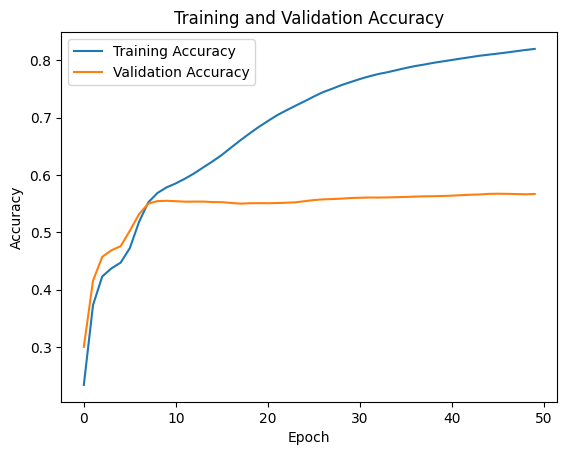

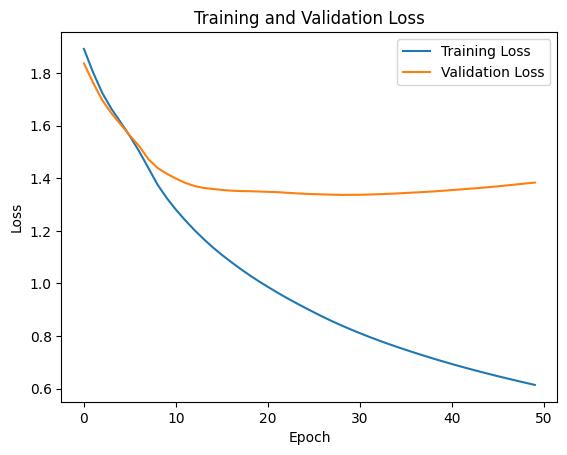

In [30]:
# Obtener métricas de entrenamiento
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Graficar precisión
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Graficar pérdida
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
predictions = sequence_model.predict(validation_ds_batch)
print(predictions.shape)

W0000 00:00:1719501990.371854 3841984 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-SXM4-40GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 40052523008 bandwidth: 1555200000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


35/35 [==============================] - 2s 9ms/step
(17909, 10, 7)


In [32]:
validation_ds

<_TensorSliceDataset element_spec=((TensorSpec(shape=(10, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.bool, name=None)), TensorSpec(shape=(10, 7), dtype=tf.float32, name=None))>

In [33]:
validation_labels = np.concatenate([labels for train_data, labels in validation_ds])
print(validation_labels.shape)

(179090, 7)


In [34]:
#indices = [i for i, arr in enumerate(validation_labels) if any(subarr[3] == 1 for subarr in arr)]
#validation_labels[indices][0]

In [35]:
#predictions[indices][0]

In [36]:
y_true = np.reshape(validation_labels, (-1, validation_labels.shape[-1]))
y_pred = np.reshape(predictions, (-1, predictions.shape[-1]))

# Eliminar las filas con -1 en y_true
valid_indices = np.where(np.all(y_true != -1, axis=1))
y_true = y_true[valid_indices]
y_pred = y_pred[valid_indices]
                    
print(y_true.shape)
print(y_pred.shape)

(173305, 7)
(173305, 7)


In [37]:
indices = np.where(y_true[:, 3] == 1)[0]
print(y_true[indices][-2])
print(y_pred[indices][-2])

[0. 0. 0. 1. 0. 0. 0.]
[0.27892834 0.22291556 0.02362378 0.03653502 0.09175786 0.29301304
 0.05322644]


In [38]:
max_indices = tf.argmax(y_pred, axis=1)
binary_pred = tf.one_hot(max_indices, depth=y_pred.shape[1])

binary_pred[0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)>

In [39]:
# Calcular la precisión
precision = tf.keras.metrics.Precision()
precision.update_state(y_true, binary_pred)
precision_result = precision.result().numpy()

print("Precisión:", precision_result)

Precisión: 0.5666715


In [40]:
# Calcular el recall
recall = tf.keras.metrics.Recall()
recall.update_state(y_true, binary_pred)
recall_result = recall.result().numpy()

print("Recall:", recall_result)

Recall: 0.5666715


In [41]:
# Calcular el F1-score
f1_score = tf.keras.metrics.F1Score()
f1_score.update_state(y_true, binary_pred)
f1_score_result = f1_score.result().numpy()

for index, value in enumerate(f1_score_result):
    print(f"F1-score {emociones[index]}: {value:.4f}")

F1-score Neutral: 0.7266
F1-score Anger: 0.2186
F1-score Disgust: 0.0000
F1-score Fear: 0.0390
F1-score Happiness: 0.5952
F1-score Sadness: 0.3125
F1-score Surprise: 0.3576


In [42]:
# Calcular el F1-score
f1_score = tf.keras.metrics.F1Score(average='macro')
f1_score.update_state(y_true, binary_pred)
f1_score_result = f1_score.result().numpy()

print(f"F1-score: {f1_score_result:.4f}")

F1-score: 0.3214


In [47]:
validation_ds

<_TensorSliceDataset element_spec=((TensorSpec(shape=(10, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.bool, name=None)), TensorSpec(shape=(10, 7), dtype=tf.float32, name=None))>

#### Calculando con for loop

In [ ]:
# Hacer predicciones en los datos de validación en lotes
predictions = []
true_labels = []

for seq_images, labels in validation_ds_batch:
    batch_predictions = sequence_model.predict(seq_images)
    predictions.extend(batch_predictions)
    true_labels.extend(labels)
    
predictions = tf.convert_to_tensor(predictions)
true_labels = tf.convert_to_tensor(true_labels)

In [52]:
_y_true = np.reshape(true_labels, (-1, true_labels.shape[-1]))
_y_pred = np.reshape(predictions, (-1, predictions.shape[-1]))

In [56]:
valid_indices = np.where(np.all(_y_true != -1, axis=1))
_y_true = _y_true[valid_indices]
_y_pred = _y_pred[valid_indices]

In [57]:
# Calcular el F1-score
f1_score = tf.keras.metrics.F1Score()
f1_score.update_state(_y_true, _y_pred)
f1_score_result = f1_score.result().numpy()

for index, value in enumerate(f1_score_result):
    print(f"F1-score {emociones[index]}: {value:.4f}")

F1-score Neutral: 0.7267
F1-score Anger: 0.2186
F1-score Disgust: 0.0000
F1-score Fear: 0.0390
F1-score Happiness: 0.5952
F1-score Sadness: 0.3125
F1-score Surprise: 0.3574


# Test model

In [18]:
fg = FrameGeneratorAffWildPoolV2(len(emociones), model, ruta_labels_validation, ruta_imagenes, MAX_SEQ_LENGTH, NUM_FEATURES, IMG_SIZE, IMG_CHANNELS, videos_names=videos_validation, verbose=False)

data_test = fg()


Generator for videos ['121-24-1920x1080']


In [19]:
# Dividir los datos en características de entrada, máscaras y etiquetas
frame_features_inputs = [data[0][0] for data in data_test]
mask_inputs = [data[0][1] for data in data_test]
labels = [data[1] for data in data_test]

# Convertir las listas en tensores de TensorFlow
frame_features_inputs_tensor = tf.convert_to_tensor(frame_features_inputs, dtype=tf.float32)
mask_inputs_tensor = tf.convert_to_tensor(mask_inputs, dtype=tf.bool)
labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)

# Crear el conjunto de datos de TensorFlow
data_test_ds = tf.data.Dataset.from_tensor_slices(((frame_features_inputs_tensor, mask_inputs_tensor), labels_tensor))

In [21]:
data_test[-14]

((array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ..., 10.911294,  0.      ,
           0.      ],
         ...,
         [ 0.      ,  0.      ,  0.      , ..., 76.568146,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ..., 35.748783,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ..., 61.6075  ,  0.      ,
           0.      ]], dtype=float32),
  array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,

In [175]:
result = sequence_model.predict(data_test_ds.batch(BATCH_SIZE))

1/1 [==============================] - 0s 26ms/step


In [176]:
result.shape

(31, 60, 7)

In [177]:
test_case = result[-14]
test_case.shape

(60, 7)

In [178]:
test_case[0]

array([0.08167878, 0.29798946, 0.38783565, 0.11805432, 0.04223242,
       0.0162622 , 0.05594712], dtype=float32)

In [179]:
max_indices = tf.argmax(test_case, axis=1)
result_pred = tf.one_hot(max_indices, depth=test_case.shape[1])

In [180]:
result_pred

<tf.Tensor: shape=(60, 7), dtype=float32, numpy=
array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.

In [112]:
_, accuracy = sequence_model.evaluate(data_test_ds.batch(BATCH_SIZE))
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

1/1 [==============================] - 0s 31ms/step - loss: 1.3330 - accuracy: 0.5069
Test accuracy: 50.69%


# Count sequences in dataset

In [109]:
sequences_count = dict()
for el in train_ds:
    idx = np.argmax(np.sum(el[1], axis=0))
    if idx not in sequences_count:
        sequences_count[idx] = 1
    else:
        sequences_count[idx] += 1

In [110]:
{ emociones[k]: v for k,v in sequences_count.items() }

{'Neutral': 3918,
 'Happiness': 1894,
 'Sadness': 1384,
 'Anger': 307,
 'Surprise': 599,
 'Fear': 171,
 'Disgust': 196}

In [154]:
## Calcular los pesos de clase inversamente proporcionales a la frecuencia de las clases
total_samples = sum(sequences_count.values())
class_weights = {}
for class_index, count in sequences_count.items():
    class_weights[class_index] = total_samples / (len(sequences_count) * count)

# Imprimir los pesos de clase
print("Pesos de clase:", class_weights)

Pesos de clase: {0: 0.30879457449135855, 4: 0.6387841303364007, 5: 0.8741742361684558, 1: 3.940902745463006, 6: 2.019794896255664, 3: 7.075187969924812, 2: 6.172740524781341}


# Resample train

In [122]:
new_train_data = []
sequences_count = dict()
for el in train_ds:
    idx = np.argmax(np.sum(el[1], axis=0))
    if idx not in sequences_count:
        sequences_count[idx] = 1
    else:
        sequences_count[idx] += 1
        
    if(sequences_count[idx] <= 300):
        new_train_data.append(el)

In [123]:
len(new_train_data)

1867

In [126]:
# Dividir los datos en características de entrada, máscaras y etiquetas
frame_features_inputs = [data[0][0] for data in new_train_data]
mask_inputs = [data[0][1] for data in new_train_data]
labels = [data[1] for data in new_train_data]

# Convertir las listas en tensores de TensorFlow
frame_features_inputs_tensor = tf.convert_to_tensor(frame_features_inputs, dtype=tf.float32)
mask_inputs_tensor = tf.convert_to_tensor(mask_inputs, dtype=tf.bool)
labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)

# Crear el conjunto de datos de TensorFlow
new_train_ds = tf.data.Dataset.from_tensor_slices(((frame_features_inputs_tensor, mask_inputs_tensor), labels_tensor))

In [127]:
new_train_ds

<_TensorSliceDataset element_spec=((TensorSpec(shape=(60, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(60,), dtype=tf.bool, name=None)), TensorSpec(shape=(60, 7), dtype=tf.float32, name=None))>

In [128]:
new_train_ds_batch = new_train_ds.batch(BATCH_SIZE)
new_train_ds_batch

<_BatchDataset element_spec=((TensorSpec(shape=(None, 60, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None, 60), dtype=tf.bool, name=None)), TensorSpec(shape=(None, 60, 7), dtype=tf.float32, name=None))>